# Analisis de redes (Prueba de concepto) 

EL siguiente es un analisis de los datos recopilados a través de los perfiles de LinkedIn. Se toman los datos relativos a los trabajos y educación declarada. El primer paso es un analisis a través de un grafo bipartito con dos subconjuntos de nodos, por un ladom las instituciones (educativas y empresas) y por el otro los actores. No se crearon tres grupos para hacer un grafo multi´partito porque hay algunas instituciones para los cuales los actores han trabajado y han estudiado. De esta forma lo que interesa es si confluyeron en este espacio. El objetivoi es ver si se forma n clusters de relaciones entre personas que compartieron los mismos espacios institucionales

## Grafo Bipartito: Actores e instituciones

Se representa en este primer grafo los actores y sus relaciones con instituciones tanto laborales como educativas.
Se asigna un peso a los vertices en funcion de cuantas vinculaciones haya declarado. Por ejemplo, si un actor estudió
el grado y el posgrado en una misma institucion se toma que el peso del vertice es igual a 2. Lo que importa es la vinculación
y su fuerza. Los nombres de las instituciones son comparadas con una tabla de sinónimos para evitar duplicaciópn de nodos y errores de tipeo. EL algoritmo de Levenshtein busca equivalencias con esa tabla para evitar un duplicado por error de tipeo. El valor de threshold para el algoritmo es una distancia igual a 5. Cualquier cosa por arriba de ese valor se considera un nodo diferente. Se pueden agregar sinónimos manualmente a la tabla.

In [2]:
import json
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from CleaningLibrary import synonym_sustitution,find_nearest_match
    
G = nx.Graph()
data = pd.read_excel (r'results_profiles.xlsx')
data['Educación'] = [json.loads(obj) for obj in [obj for obj in data['Educación'].values]]     
data['Trabajos'] = [json.loads(obj) for obj in [obj for obj in data['Trabajos'].values]]     


syn_dict = pd.read_csv("Institutions.csv") 
forb_inst =["Autónomo"]
inst= []
for person in data.index:   
    prs_name=data['Nombre'][person]
    G.add_node(prs_name, tipo='Persona')
    for degree in data['Educación'][person]:
        insti = synonym_sustitution(syn_dict,degree['institution'].strip())
        if (insti not in inst) and (insti !='') and (insti not in forb_inst):
            G.add_node(insti, tipo='Institución')
            inst.append(insti)
        if (insti  !='') and (insti not in forb_inst):
            if not (G.has_edge(prs_name,insti)) : 
                G.add_edge(prs_name,insti, v=1)
            else :
                G.add_edge(prs_name,insti,v=G[prs_name][insti]['v']+1)
                
    for trabajo in data['Trabajos'][person]:
        comp = synonym_sustitution(syn_dict,trabajo['company']['name'].strip())
        if (comp not in inst) and (comp !='')  and (comp not in forb_inst):
            G.add_node(comp, tipo='Institución' )
            inst.append(comp)
        if (comp !='') and (comp not in forb_inst):
            if not (G.has_edge(prs_name,comp)) : 
                G.add_edge(prs_name,comp, v=1)
            else :
                G.add_edge(prs_name,comp,v=G[prs_name][comp]['v']+1)

### Análisis de  similitud en nombres de instituciones

Este comando devuelve una tabla donde se comparan los nombres de las instituciones para detectar posibles equivalencias.  Si el valor de la columna similarities es igual a 1 es que son ambas etiquetas iguales.

In [3]:

#Para analizar la similitud de los nombres de las instituciones
simil_analisis = find_nearest_match(inst,0.5,1000)
print(simil_analisis)


                                            left_side  \
1                     Universidad Católica de Córdoba   
4       Facultad Latinoamericana de Ciencias Sociales   
20                   Universidad Nacional de La Plata   
55  Universidad Latinoamericana de Ciencia y Tecno...   
82                    Universidad Nacional de Córdoba   
83                    Universidad Nacional de Córdoba   

                                           right_side  similairity  
1                     Universidad Nacional de Córdoba     0.568828  
4   Universidad Latinoamericana de Ciencia y Tecno...     0.513279  
20                    Universidad Nacional de Córdoba     0.618650  
55      Facultad Latinoamericana de Ciencias Sociales     0.513279  
82                   Universidad Nacional de La Plata     0.618650  
83                    Universidad Católica de Córdoba     0.568828  


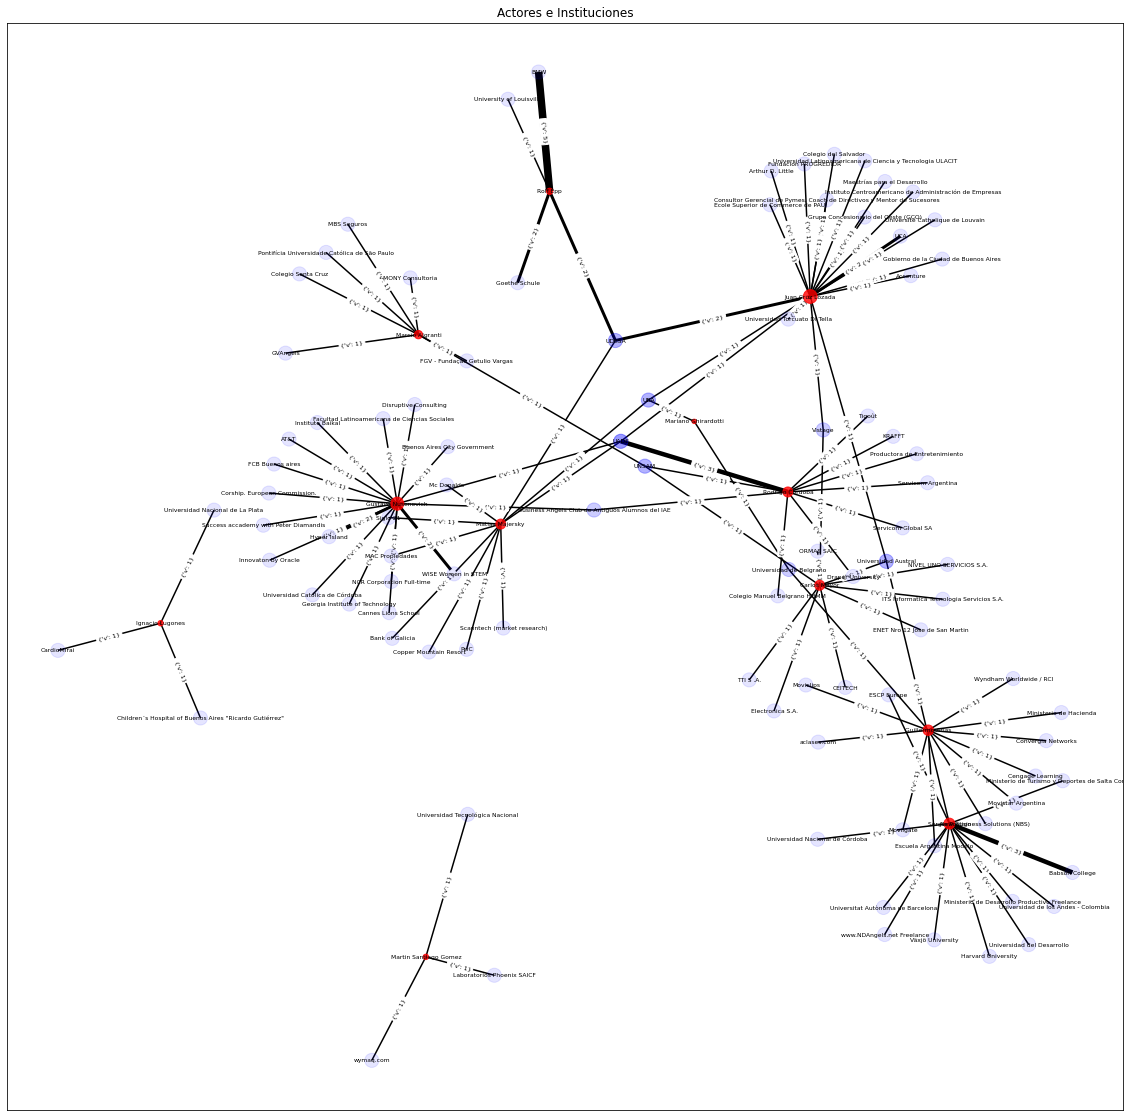

In [4]:
personas = [x for x,y in G.nodes(data=True) if y['tipo']=="Persona"]
instituciones = [x for x,y in G.nodes(data=True) if y['tipo']=="Institución"]

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G,k=0.1,iterations=20)


#Grafo Bipartito

plt.title("Actores e Instituciones")
node_size = [[G.degree(v)*40,10][not (nx.get_node_attributes(G, 'tipo')[v]=="Institución")] for v in G]
node_color = [0.0005*[1, 2][nx.get_node_attributes(G, 'tipo')[v]=="Institución"] for v in G]
edge_width = [1.5*G[u][v]['v'] for u,v in G.edges()]
#nx.draw_networkx(G, pos,font_size=7, node_color=node_color, node_size=node_size,alpha=0.7,width=edge_width,edge_color='.4');

node_size = [[G.degree(v)*10,10][not (nx.get_node_attributes(G, 'tipo')[v]=="Persona")] for v in personas]
node_alpha = [[G.degree(v)*0.1,10][not (nx.get_node_attributes(G, 'tipo')[v]=="Institución")] for v in instituciones]
nx.draw_networkx_nodes(G, pos, instituciones, node_color="b", node_size=200,alpha=node_alpha, label=instituciones)
nx.draw_networkx_nodes(G, pos, personas, node_color="r", node_size=node_size,alpha=0.8)
edges=nx.draw_networkx_edges(G,pos,width=edge_width)
nx.draw_networkx_labels(G, pos, font_size=6)
edge_labels = nx.draw_networkx_edge_labels(G, pos,font_size=6)


### Proyeccion de actores en base a instituciones
El siguiente grafico muestra que actores estan relacionados con que otros en base a su pertenencia institucional. El peso de los vínculos refiere a la cantidad de veces que se vincularon en base a una o mas instituciones.


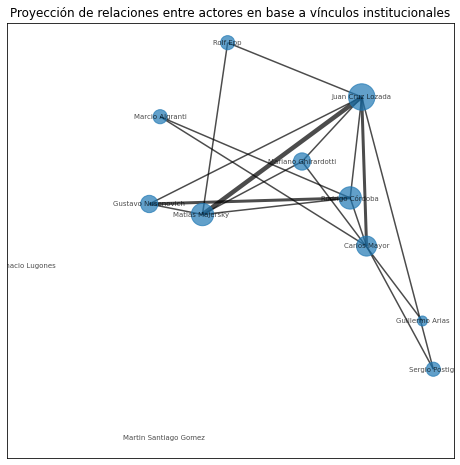

In [5]:
#Grafo Proyectando las personas que |están relacionadas por pertenencias institucionales en general
plt.figure(figsize=(8, 8))
plt.title("Proyección de relaciones entre actores en base a vínculos institucionales")
P =bipartite.weighted_projected_graph(G, personas,False)
edge_width = [1.5*P[u][v]['weight'] for u,v in P.edges()]
node_size = [P.degree(v)*100 for v in P]

nx.draw_networkx(P,pos,font_size=7,alpha=0.7,width=edge_width,node_size=node_size)
#nx.draw_networkx_edge_labels(P, pos, font_size=6)



### Exportar a formato Gephi

Esto exporta a formato de archivo gephi para poder trabajarlo sobre esa herramienta.

In [6]:


nx.write_gexf(G, "Bipartite-Gephi.gexf")
nx.write_gexf(G, "Bipartite-Proy-Person-Gephi.gexf")

### Grafico con plotly

Este es el mismo análisis de redes pero con la librería plotly. El objetivo es experimentar con la librería

In [34]:
############################plotly########################################

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
import chart_studio.plotly as plotly
import chart_studio as cs

for n, p in pos.items():
    G.nodes[n]['pos'] = p
    
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='all',
    mode='lines')

for edge in G.edges(): 
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
    
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='RdBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))




for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])

for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = adjacencies[0] +' # of connections: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])



    
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Actores y relaciones con empresas e instituciones educatívas',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="No. of connections",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig

###Crea un HTML estático con un evento on click en los nodos##############
'''
import re
from plotly.offline import plot

# Get HTML representation of plotly.js and this figure
plot_div = plot(fig, output_type='div', include_plotlyjs=True)

# Get id of html div element that looks like
# <div id="301d22ab-bfba-4621-8f5d-dc4fd855bb33" ... >
res = re.search('<div id="([^"]*)"', plot_div)
div_id = res.groups()[0]

# Build JavaScript callback for handling clicks
# and opening the URL in the trace's customdata 
js_callback = """
<script>
var plot_element = document.getElementById("{div_id}");
plot_element.on('plotly_click', function(data){{
    console.log(data);
    var point = data.points[0];
    if (point) {{
        console.log("hi");
        window.open("http://www.circularinnova.com");
    }}
}})
</script>
""".format(div_id=div_id)

# Build HTML string
html_str = """
<html>
<body>
{plot_div}
{js_callback}
</body>
</html>
""".format(plot_div=plot_div, js_callback=js_callback)

# Write out HTML file
with open('hyperlink_fig.html', 'w') as f:
    f.write(html_str)

'''

## Analisis de formación de los actores

Este grafo es lo mismo que el anterior pero solo considera las instituciones educativas. El objetivo es ver si hay clusters de relaciones que hablen de la importancia de determinados nucleos formativos. Este es un multigrafo, por lo tanto los vínculos entre instituciones y actores pueden ser múltiples. La etiqueta muestra el título del actor en esa institución. 

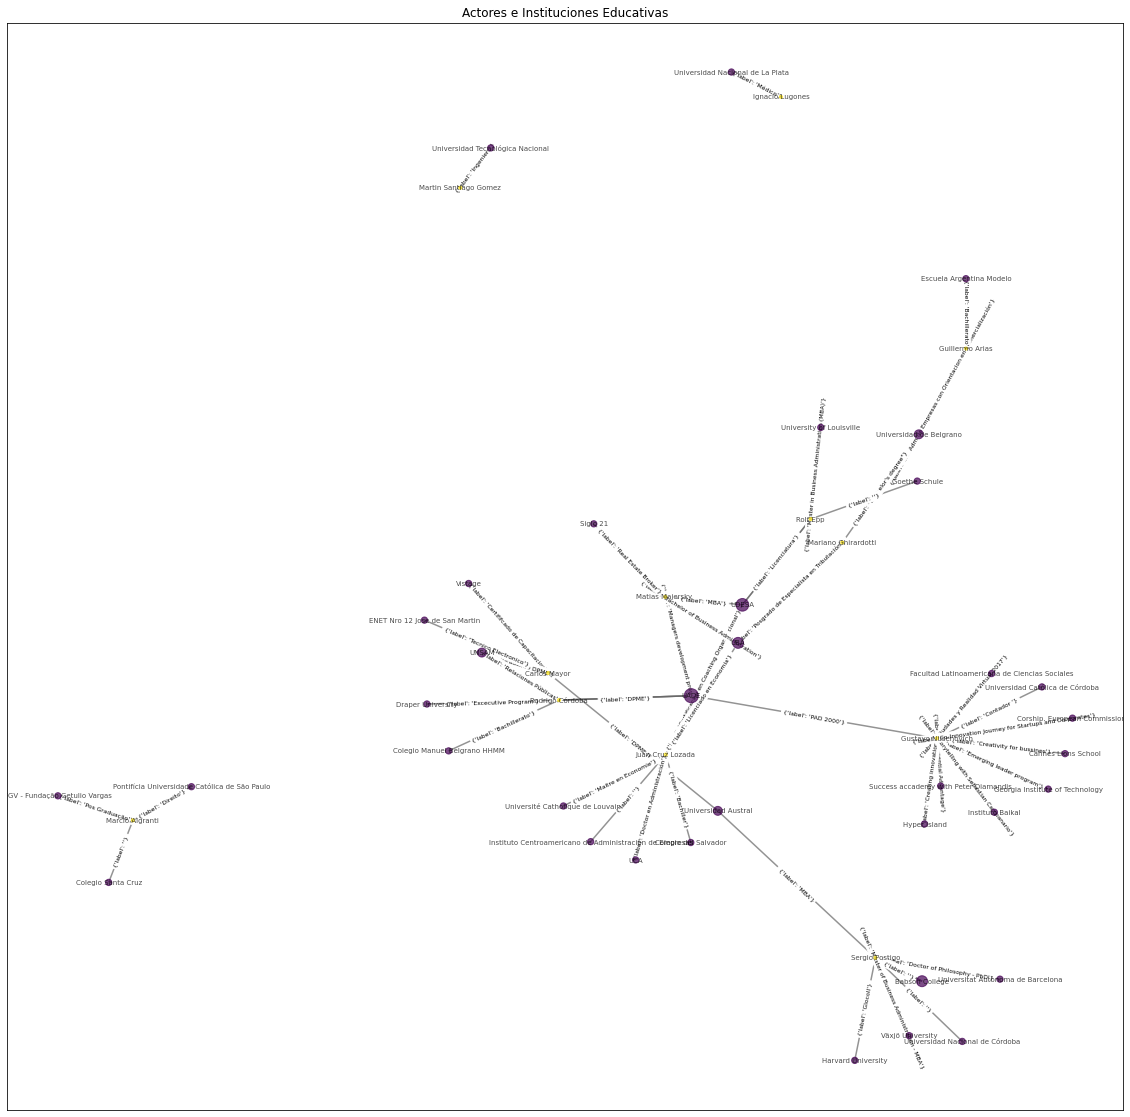

In [8]:

####################EDUCACIÓN##########################################3
    
G = nx.MultiGraph()
inst= []
for person in data.index:   
    prs_name=data['Nombre'][person]
    G.add_node(prs_name, tipo='Persona')
    for degree in data['Educación'][person]:
        insti = synonym_sustitution(syn_dict,degree['institution'].strip())
        if (insti not in inst) and (insti !='') and (insti not in forb_inst):
            G.add_node(insti, tipo='Institución')
            inst.append(insti)
        if (insti  !='') and (insti not in forb_inst):
             G.add_edge(prs_name,insti, label=degree['degree'],key=degree['degree'])
           
        

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G,k=0.1,iterations=20)

#Grafo Bipartito
plt.title("Actores e Instituciones Educativas")
node_size = [[G.degree(v)*40,10][not (nx.get_node_attributes(G, 'tipo')[v]=="Institución")] for v in G]
node_color = [0.0005*[1, 2][nx.get_node_attributes(G, 'tipo')[v]=="Persona"] for v in G]
edge_width = 1.5
nx.draw_networkx(G, pos,font_size=7, node_color=node_color,node_size=node_size,alpha=0.7,width=edge_width,edge_color='.4')
x =nx.draw_networkx_edge_labels(G, pos, font_size=6)
